In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import PatchExtractor as PE
from sklearn import linear_model


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#random variation of parameters
def randpar(par,var):
    '''This function adds gaussian noise to parameters stored in a dictionary. 
    var is the std of the gaussian distribution (1 = 100% of the not noisy value).'''
    flag = 0
    while flag == 0:
        temp = cp.deepcopy(par)
        for key in par.keys():
            temp[key]=par[key]*(1+var*plb.randn())
            #if temp[key] < 0:
            #    flag = 0
            #    break
            #else:
                #flag =1
            if temp[key] < 0:
                temp[key] = 0
        flag = 1            
    return temp  

# 2D Lotka-Volterra Model

In [ ]:
#2D Lotka-Volterra
def LVder(x,t,p):
    der0 = p['a']*x[0] - p['b']*x[0]*x[1]
    der1 = -p['c']*x[1] + p['d']*x[0]*x[1]
    return [der0,der1]



LVpar = dict(a=0.4,b=0.4,c=0.1,d=0.2)

# Function to return trajectories

In [ ]:
# for fixed Delta t solve 300 trajectories
def traj_solve(N,dt,mod,mod_par,var):
    t0 = 0
    tend = 80
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        yinit = plb.rand(2)
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time    

## Example

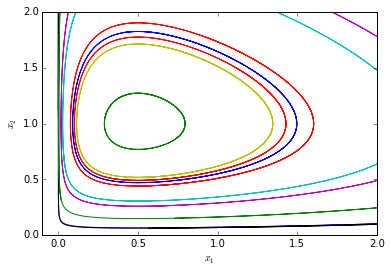

In [ ]:
N = 10
traj,time = traj_solve(N,0.1,LVder,LVpar,0.0)

for i in range(N):
    plot(traj[i,:,0],traj[i,:,1])
    xlabel("$x_1$")
    ylabel("$x_2$")
    xlim((-0.10,2))
    ylim((0,2))

# trajectories to samples of f

In [ ]:
def traj_der(traj,time):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt
                
    return trajder            

In [ ]:
time[1]-time[0]

0.10012515644555695

## Example

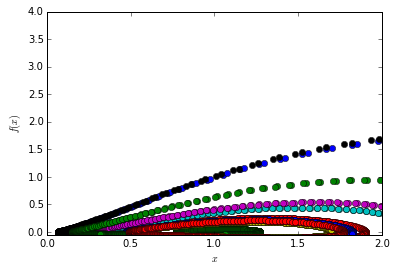

In [ ]:
trajder = traj_der(traj,time)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,2))
    ylim((-0.05,4))

# Scale and discretize measurments to fit on a 128x128 grid

In [ ]:
#convert discrete index to x1,x2 position in the model

#continuous scaling
#127 -> 2
#0 -> 0
def ind_to_x(i):
    return i*2./127.


In [ ]:
# convert x position to discrete index

#2 -> 255
#0 -> 0
def x_to_ind(x):
    ind = x/2.*127.
    return int(round(ind))    

In [ ]:
ind_to_x(x_to_ind(2.35))

2.3464566929133857

In [ ]:
def traj_to_f_meas(traj,trajder,jj):
    N,Nt,Nvar = np.shape(traj)
    f_meas = np.full((N,128,128),-100.)
    for k in range(N):
        for i in range(Nt-1):
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            #make sure index fits into the 256 array
            if ind0 < 128 and ind1 < 128 and ind0 > -1 and ind1 > -1:
                f_meas[k,ind0,ind1] = trajder[k,i,jj]
    return f_meas  

def traj_to_f_m(traj,trajder,Ntraj,jj):
    N,Nt,Nvar = np.shape(traj)
    f_m = np.full((128,128),-100.)
    touched = np.full((128,128),0.)
    s = sorted(permutation(N)[:Ntraj])
    for k in s:
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,0]+traj[k,i,0])/2.)
            ind1 = x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)
            if  (ind0 < 128) and (ind1 < 128):
                if (ind0 >= 0) and (ind1 >= 0):
                    if touched[ind0,ind1] == 0.:
                        f_m[ind0,ind1] = trajder[k,i,jj]
                    else:    
                        f_m[ind0,ind1] += trajder[k,i,jj]
                        
                    touched[ind0,ind1] +=1.
                    
    for i in range(128):
        for j in range(128):
            if touched[i,j]!=0.:
                f_m[i,j]/=float(touched[i,j])
    return f_m

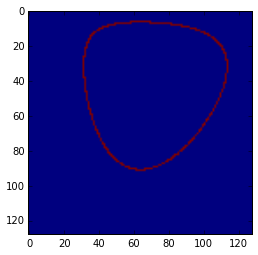

In [ ]:
f_meas = traj_to_f_meas(traj,trajder,0)
for i in range(10):
    imshow(f_meas[i])
#ylim((-.05,3))
#xlim((-1,256))

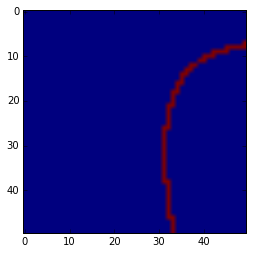

In [ ]:
imshow(f_meas[9][:50,:50])

# Sparsely reconstruct under-sampled data in basis

In [ ]:
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = True):
    clf = linear_model.Lasso(alpha=0.000001, copy_X=True, fit_intercept=False, max_iter=3000, tol=0.00000000001)

    #create array for reconstructed data
    recdata = np.full(data.shape,0.)
    
    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
            clf.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,clf.coef_)
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                print("not enough data!\n")
                #print(i)
                continue
            #elif len(rm) == ps1*ps2:
                #recdata[i,:] = data[i,:]
                #continue
        clf.fit(basis[:,rm].T, data[i,rm])
        #(3) reconstruct patch from fit coefficients
        recdata[i,:] = np.dot(basis.T,clf.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata

In [ ]:
def rec_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    from itertools import product as pd
    
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    touched = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, pd(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p
        touched[i:i + p_h, j:j + p_w] +=1

    #story checks out until here, I think    
    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            
            #img[i, j] /= float(min(i + 1, p_h, i_h - i) *
             #                  min(j + 1, p_w, i_w - j))
            img[i,j]/=float(touched[i,j])    
    return img

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = True):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    print(patch_size)
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    print("shape of data",data.shape)
    datarec = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = rec_from_patches_2d(datarec, imsize)
    return rec

# learn basis from data

In [ ]:
#number of trajectories to include
def f_prep(N,NTraj,f_meas,b_size):
    #start with a random basis
    r_basis = np.random.rand(100,b_size)

    #sample randomly from all trajectories
    s = sorted(permutation(N)[:NTraj])
    f_m = np.full((128,128),-100.)
    #for fixed (x1,x2) average over all trajectory measurements (only those values that are not -100)
    for i in range(128):
        for j in range(128):
            col = [f_meas[k,i,j] for k in s if f_meas[k,i,j]!= -100.]
            if col == []:
                f_m[i,j] = -100.
            else:
                f_m[i,j] = np.mean(col)
    return f_m,r_basis

In [ ]:
# learn basis, return reconstruction and basis
def basis_and_rec(f_m,init_basis):
    print("starting rec...")
    b_size = init_basis.shape
    b_s = int(np.sqrt(b_size[1]))
    #print(b_size)
    #reconstruct sparsely in random basis
    print("first rec in random basis")
    rec = image_rec(f_m,init_basis,1,b_s,b_s,real_data = True)
    
    tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=1, n_iter=1000 )
    # resize to basis size
    datarec = extract_patches_2d(rec,(b_s,b_s))
    datarec = datarec.reshape(datarec.shape[0], -1)
    print("learning basis")
    V = tempdic.fit(datarec).components_
    print("second rec, in learned basis")
    rec = image_rec(f_m,V,1,b_s,b_s,real_data = True)
    
    return V,rec

# measure Error

In [ ]:
def norm_1(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)
    if np.linalg.norm(r)!=0.:
        norm = 1. - abs(np.dot(d,r))/np.linalg.norm(d)/np.linalg.norm(r)
    else:
        norm = 1. 
    return norm

def norm_2(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)
    return norm

def norm_3(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)/np.linalg.norm(d)
    return norm

# test PatchExtractor

In [ ]:
a = np.arange(25).reshape(5,5,order='F')
b = np.arange(25).reshape(5,5,order='C')
pe = PE((4,4))
print(pe.transform(array([a,b])).shape)

# pe extracts patches separately from multiple images and concatenates them as one patch array

(8, 4, 4)


# Running Script

In [ ]:
#create reference function f_ref
f_ref = np.full((2,128,128),0.)
for i in range(128):
    for j in range(128):
        f_ref[0,i,j] = LVder([ind_to_x(i),ind_to_x(j)],1,LVpar)[0]
        f_ref[1,i,j] = LVder([ind_to_x(i),ind_to_x(j)],1,LVpar)[1]
        

In [ ]:
# generate trajectories
traj,time = traj_solve(100,0.01,LVder,LVpar,0.0)        
#generate derivatives
trajder = traj_der(traj,time)
#rescale to sample f

In [ ]:
traj.shape

(200, 8000, 2)

In [ ]:
print(np.min(traj[:,:,0]),np.max(traj[:,:,0]))
print(np.min(traj[:,:,1]),np.max(traj[:,:,1]))

-1.34225364455e-10 12.6032085707
0.0019441930689 8.36940776747


In [ ]:
#make one f_meas per dimension of the system
f_meas0 = traj_to_f_meas(traj,trajder,0)
f_meas1 = traj_to_f_meas(traj,trajder,1)

In [ ]:
f_m0,r_basis = f_prep(30,30,f_meas0,400)
f_m1,r_basis = f_prep(30,30,f_meas1,400)

NameError: name 'f_prep' is not defined

In [ ]:
f_M0 = traj_to_f_m(traj,trajder,100,0)
f_M1 = traj_to_f_m(traj,trajder,100,1)

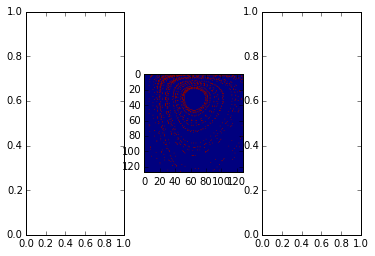

In [ ]:
subplot(1,3,1)
#imshow(f_m0)
subplot(1,3,2)
imshow(f_M0)
subplot(1,3,3)
#imshow(f_m0-f_M0)

In [ ]:
(128**2-np.sum(isnan(f_m1)))/128/128

0.099365234375

True

In [ ]:
pe = PE((25,25))
patches = reshape(pe.transform(array([f_M0,f_M1])),(-1,625),order='C')
for i in range(patches.shape[0]):
    m = np.mean(patches[i][[patches[i]!=-100.]])
    patches[i][patches[i]==-100.]=m

//anaconda/envs/py3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
//anaconda/envs/py3/lib/python3.4/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
pe = PE((25,25))
patches = reshape(pe.transform(array([f_M0,f_M1])),(-1,625),order='C')
for i in range(patches.shape[0]):
    m = [np.random.rand() for j in range(len(patches[i,:])) if patches[i,j]==-100.]
    patches[i][patches[i]==-100.]= m

In [ ]:
tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.1, n_iter=10000 )
V = tempdic.fit(patches).components_

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':


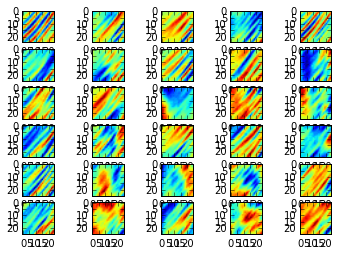

In [ ]:
for i,comp in enumerate(V):
    subplot(6,5,1+i)
    imshow(comp.reshape(25,25))

In [ ]:
from time import time as Ttime

In [ ]:
t0=Ttime()
rec0_old = image_rec(f_M0,V,1,25,25)
print(Ttime()-t0)

(25, 25)
shape of data (10816, 625)
139.09480786323547


In [ ]:
t0=Ttime()
rec1_old = image_rec(f_M1,V,1,25,25)
print(Ttime()-t0)

(25, 25)
shape of data (10816, 625)
133.14194798469543


In [ ]:
print(norm_1(f_ref[0],rec0_old),norm_1(f_ref[1],rec1_old))

3.92315456709e-05 4.95986842731e-05


In [ ]:
#np.savez("2drecb.txt",rec0_old,rec1_old,f_M0,f_M1)
#Ntraj = 30, dt = 5 norm = (0.0419288635567,0.0257632749023), gridpoint fraction sampled: 0.0223388671875
recfile = np.load("2drecb.txt.npz")
Recb0 = recfile['arr_0']
Recb1 = recfile['arr_1']
f_M0=recfile['arr_2']
f_M1=recfile['arr_3']

In [ ]:
#np.savez("2drecg.txt",rec0_old,rec1_old,f_M0,f_M1)
#Ntraj = 100, dt = 0.01 norm = (3.92315456709e-05, 4.95986842731e-05),gridpoint fraction sampled: 0.678955078125
recfile = np.load("2drecg.txt.npz")
Recg0 = recfile['arr_0']
Recg1 = recfile['arr_1']
f_M0=recfile['arr_2']
f_M1=recfile['arr_3']

In [ ]:
#np.savez("2drec.txt",rec0,rec1)
#recfile = np.load("2drec.txt.npz")
#Rec0 = recfile['arr_0']
#Rec1 = recfile['arr_1']

In [ ]:
np.sum(f_M0>-100.)/128**2

0.0223388671875

In [ ]:
print([vmin0,vmax0,vmin1,vmax1])

[-0.80000000000000004, 0.80000000000000004, -0.20000000000000001, 0.60000000000000009]


In [ ]:
f_m0 = np.full(f_M0.shape,np.nan)
f_m0[f_M0>-100]=f_M0[f_M0>-100]
f_m1 = np.full(f_M1.shape,np.nan)
f_m1[f_M1>-100]=f_M1[f_M1>-100]

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


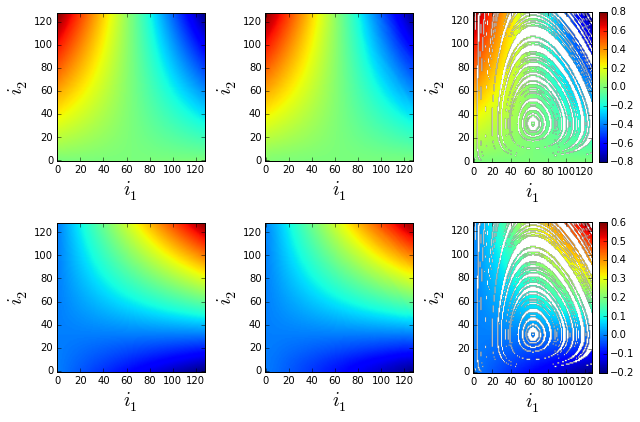

In [ ]:
f=figure(figsize=(9,6))
vmin0 = np.min(f_ref[0])
vmax0 = np.max(f_ref[0])
vmin1 = np.min(f_ref[1])
vmax1 = np.max(f_ref[1])
subplot(2,3,1)
imshow(f_ref[0],vmin =vmin0,vmax=vmax0,origin='lower')
xlabel("$i_1$",size='20')
ylabel("$i_2$",size='20')
subplot(2,3,2)
imshow(Rec0,vmin =vmin0,vmax=vmax0,origin='lower')
xlabel("$i_1$",size='20')
ylabel("$i_2$",size='20')
subplot(2,3,3)
imshow(f_m0,vmin =vmin0,vmax=vmax0,origin='lower',aspect = '1.27')
xlabel("$i_1$",size='20')
ylabel("$i_2$",size='20')
colorbar(shrink=0.94)
subplot(2,3,4)
imshow(f_ref[1],vmin =vmin1,vmax=vmax1,origin='lower')
xlabel("$i_1$",size='20')
ylabel("$i_2$",size='20')
subplot(2,3,5)
imshow(rec1_old,vmin =vmin1,vmax=vmax1,origin='lower')
xlabel("$i_1$",size='20')
ylabel("$i_2$",size='20')
subplot(2,3,6)
imshow(f_m1,vmin =vmin1,vmax=vmax1,origin='lower',aspect = '1.27')
xlabel("$i_1$",size='20')
ylabel("$i_2$",size='20')
colorbar(shrink=0.94)
tight_layout()
#f.savefig("ofd/2d_example_rec_g.pdf")

In [ ]:
(128**2-sum(isnan(f_m1)))/128**2

0.678955078125

In [ ]:
sum(f_M0>-100.)/128/128

0.0235595703125

In [ ]:
#Recb0=rec0
#Recb1=rec1
#Recold0=rec0_old
#Recold1=rec1_old

In [ ]:
Rec1.shape

(128, 128)

In [ ]:
#test ODE
def LVrecgder(x,t):
    i = x_to_ind(x[0])
    j = x_to_ind(x[1])
    if i < 0:
        i=0
    elif i >127:
        i=127
    if j < 0:
        j=0
    elif j >127:
        j=127        
    der0 = Recg0[i,j]
    der1 = Recg1[i,j]
    return der0,der1

def LVrecbder(x,t):
    i = x_to_ind(x[0])
    j = x_to_ind(x[1])
    if i < 0:
        i=0
    elif i >127:
        i=127
    if j < 0:
        j=0
    elif j >127:
        j=127        
    der0 = Recb0[i,j]
    der1 = Recb1[i,j]
    return der0,der1

def LVrecoldder(x,t):
    i = x_to_ind(x[0])
    j = x_to_ind(x[1])
    if i < 0:
        i=0
    elif i >127:
        i=127
    if j < 0:
        j=0
    elif j >127:
        j=127        
    der0 = Recold0[i,j]
    der1 = Recold1[i,j]
    return der0,der1

def LVmeasder(x,t):
    i = x_to_ind(x[0])
    j = x_to_ind(x[1])
    if i < 0:
        i=0
    elif i >127:
        i=127
    if j < 0:
        j=0
    elif j >127:
        j=127 
    der0 = f_m0[i,j]
    der1 = f_m1[i,j]
    return der0,der1

def LVrefder(x,t):
    i = x_to_ind(x[0])
    j = x_to_ind(x[1])
    if i < 0:
        i=0
    elif i >127:
        i=127
    if j < 0:
        j=0
    elif j >127:
        j=127 
    der0 = f_ref[0,i,j]
    der1 = f_ref[1,i,j]
    return der0,der1

In [ ]:
# find trajectories that stay in between (0,2)x(0,2)
l = []
for i in range(99):
    ind00 = x_to_ind(np.min(traj[i,:,0]))
    ind01 = x_to_ind(np.max(traj[i,:,0]))
    ind10 = x_to_ind(np.min(traj[i,:,1]))
    ind11 = x_to_ind(np.max(traj[i,:,1]))
    if ind00 > 0 and ind01 < 120 and ind10 > 0 and ind11 <120 :
        l.append(i)

print(len(l))    

40


In [ ]:
# solve in original and recontructed function
t0 = 0
tend = 55
dt = 0.1
Nt = (tend-t0)/float(dt)
time = np.linspace(t0,tend,Nt)
n = 10
trajor = np.full((n,len(time),2),-3.)
trajrecg = np.full((n,len(time),2),-3.)
trajrecb = np.full((n,len(time),2),-3.)
#trajmeas = np.full((n,len(time),2),-3.)
trajref = np.full((n,len(time),2),-3.)
var = 0.

for i in range(n):
    print(i)
    yinit = traj[l[i],0,:]
    trajor[i,:,:] = odeint(LVder,yinit,time,args = (LVpar,))
    #trajrec[i,:,:] = odeint(LVrecder,yinit,time)
    trajrecg[i,:,:] = odeint(LVrecgder,yinit,time)
    trajrecb[i,:,:] = odeint(LVrecbder,yinit,time)
    trajref[i,:,:] = odeint(LVrefder,yinit,time)
    #trajmeas[i,:,:] = odeint(LVmeasder,yinit,time)


0
1
2
3
4
5
6
7
8
9


//anaconda/envs/py3/lib/python3.4/site-packages/scipy/integrate/odepack.py:156: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Difference in solutions is problem of reconstruction not of grid sampling of the f's

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


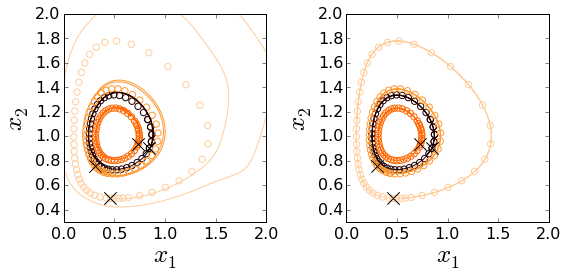

In [ ]:
figure(figsize=(8,4))
te =600
te0 =360
cmap = plt.get_cmap("gist_heat")
for i in [1,7,8,9]:
    subplot(1,2,1)
    #plot(trajor[i,:te0,0],trajor[i,:te0,1],'--',color = cmap(i/float(n)))
    scatter(trajor[i,:te0,0][::8], trajor[i,:te0,1][::8], s=40, facecolors='none', edgecolors=cmap(i/float(n)))
    #scatter(trajor[i,0,0],trajor[i,0,1],s=40,facecolors=cmap(i/float(n)),edgecolors='none')
    #plot(trajrec[i,:te,0],trajrec[i,:te,1],color = cmap(i/float(n)))
    plot(trajrecb[i,:te,0],trajrecb[i,:te,1],color = cmap(i/float(n)))
    #scatter(trajor[i,0,0],trajor[i,0,1],c='k',marker ='x')\
    for k in [1,7,8,9]:
        plot(trajor[k,0,0],trajor[k,0,1],'kx',markersize=12)
    ylim(0.3,2)
    xlim(0,2)
    xlabel("$x_1$",size='25')
    ylabel("$x_2$",size='25') 
    tick_params(axis='both', which='major', labelsize=16)
    
    subplot(1,2,2)
    #plot(trajor[i,:te0,0],trajor[i,:te0,1],'--',color = cmap(i/float(n)))
    scatter(trajor[i,:te0,0][::8], trajor[i,:te0,1][::8], s=40, facecolors='none', edgecolors=cmap(i/float(n)))
    #plot(trajrec[i,:te,0],trajrec[i,:te,1],color = cmap(i/float(n)))
    plot(trajrecg[i,:te,0],trajrecg[i,:te,1],color = cmap(i/float(n)))
    #scatter(trajor[i,0,0],trajor[i,0,1],c='k',marker ='x')
    ylim(0.3,2)
    xlim(0,2)
    xlabel("$x_1$",size='25')
    ylabel("$x_2$",size='25') 
    tick_params(axis='both', which='major', labelsize=16)
    for k in [1,7,8,9]:
        plot([trajor[k,0,0]],[trajor[k,0,1]],'kx',markersize=12)

    
tight_layout()    
#savefig("ofd/2d_rec_phasespace_gb.pdf") 

In [ ]:
n = 1024
X = np.random.normal(0, 1, n)
Y = np.random.normal(0, 1, n)
T = np.arctan2(Y, X)

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


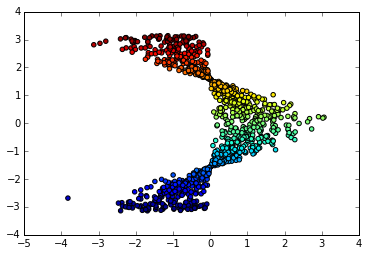

In [ ]:
scatter(X,T,c=T)

//anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


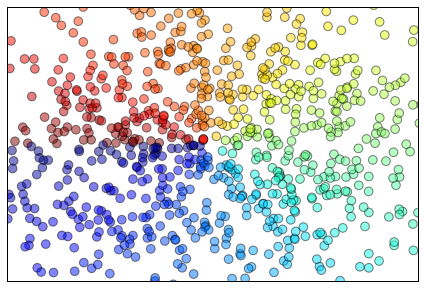